# Trénovanie modelu na základe DST indexu 1h dopredu 24h dozadu

### Inštalácia knižníc

In [ ]:
!pip install pyarrow
!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

### Import knižníc

In [2]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report

2024-03-31 14:15:19.935169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Načitanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [32]:
df = pd.read_csv('omni_full.csv')
len(df)

520443

In [33]:
df.columns

Index(['time1', 'Rot$', 'IMF', 'PLS', 'IMF_PTS', 'PLS_PTS', 'ABS_B', 'F',
       'THETA_AV', 'PHI_AV', 'BX_GSE', 'BY_GSE', 'BZ_GSE', 'BY_GSM', 'BZ_GSM',
       'SIGMA$ABS_B', 'SIGMA$B', 'SIGMA$Bx', 'SIGMA$By', 'SIGMA$Bz', 'T', 'N',
       'V', 'PHI$V', 'THETA$V', 'Ratio', 'Pressure', 'SIGMA$T', 'SIGMA$N',
       'SIGMA$V', 'SIGMA$PHI$V', 'SIGMA$THETA$V', 'SIGMA$ratio', 'E', 'Beta',
       'Mach_num', 'Mgs_mach_num', 'PR$FLX_1', 'PR$FLX_2', 'PR$FLX_4',
       'PR$FLX_10', 'PR$FLX_30', 'PR$FLX_60', 'MFLX', 'R', 'F10_INDEX', 'KP',
       'DST', 'AE', 'AP_INDEX', 'AL_INDEX', 'AU_INDEX', 'PC_N_INDEX',
       'Solar_Lyman_alpha', 'Proton_QI'],
      dtype='object')

In [34]:
features = ['time1',
            'DST']

In [35]:
df = df[features]
df

,time1,DST
0,1963-01-01 01:00:00,-5.0
1,1963-01-01 02:00:00,-5.0
2,1963-01-01 03:00:00,-3.0
3,1963-01-01 04:00:00,-3.0
4,1963-01-01 05:00:00,-6.0
...,...,...
520438,2022-05-13 12:00:00,2.0
520439,2022-05-13 13:00:00,4.0
520440,2022-05-13 14:00:00,5.0
520441,2022-05-13 15:00:00,5.0


In [37]:
#odstranenie duplicitnych hodnot(hodnoty sa opakovali len na zaciatku kazdeho roka 01.01 o 00:00:00)
df = df.drop_duplicates(subset='time1', keep='first').copy()

In [38]:
df['time1']=pd.to_datetime(df['time1'])

In [39]:
df.dropna(inplace=True)
print(len(df))

520384


In [40]:
predicted_label = 'DST'

In [41]:
df.describe()

,DST
count,520384.000000
mean,-14.124921
std,22.034855
min,-589.000000
25%,-22.000000
50%,-10.000000
75%,-1.000000
max,81.000000


In [42]:
df[predicted_label].describe()

count    520384.000000
mean        -14.124921
std          22.034855
min        -589.000000
25%         -22.000000
50%         -10.000000
75%          -1.000000
max          81.000000
Name: DST, dtype: float64

In [43]:
df.head()

,time1,DST
0,1963-01-01 01:00:00,-5.0
1,1963-01-01 02:00:00,-5.0
2,1963-01-01 03:00:00,-3.0
3,1963-01-01 04:00:00,-3.0
4,1963-01-01 05:00:00,-6.0


<AxesSubplot:>

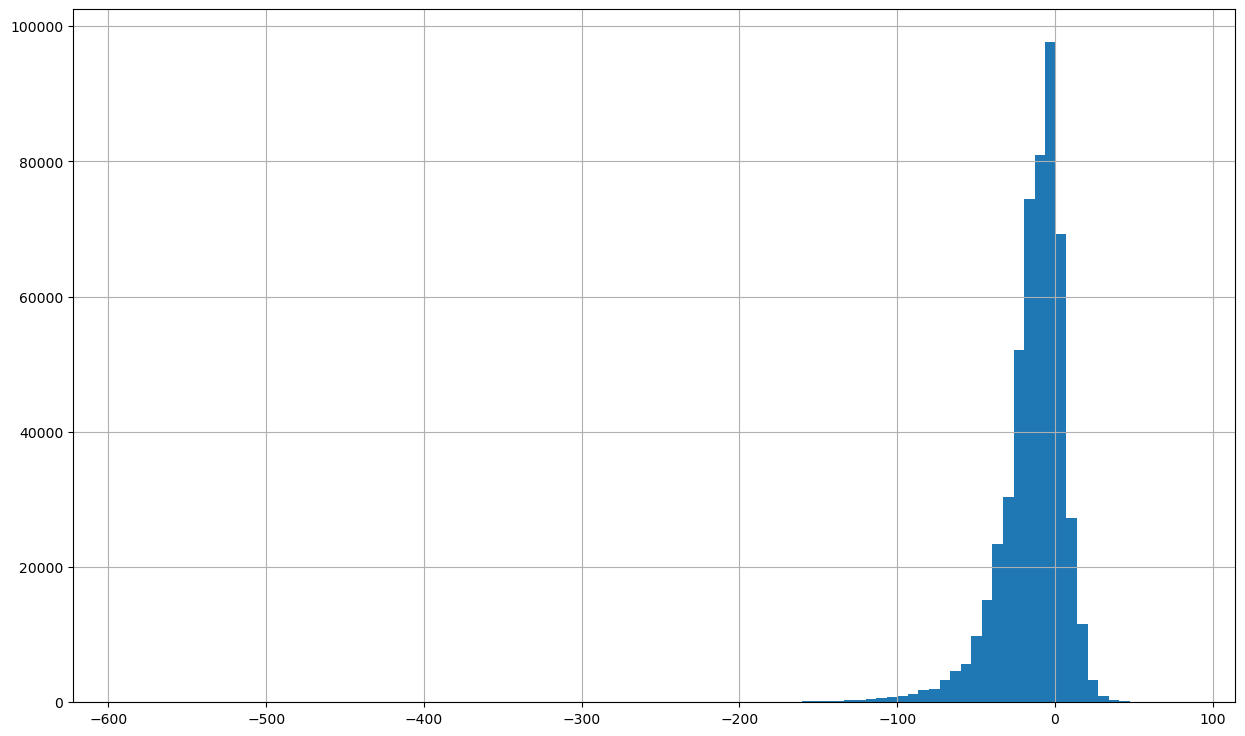

In [44]:
df[predicted_label].hist(bins=100)

In [45]:
# transform label using sigmoid
variance = df[predicted_label].std()
df["contcontinuous_transforminuous_transform"] = df[predicted_label].apply(lambda x: expit(2 * ((x - 0.2) / variance)))
df["contcontinuous_transforminuous_transform"].describe()

count    5.203840e+05
mean     3.113723e-01
std      2.271244e-01
min      5.948467e-24
25%      1.176381e-01
50%      2.837764e-01
75%      4.727973e-01
max      9.993474e-01
Name: contcontinuous_transforminuous_transform, dtype: float64

In [46]:
# choose one of them
# define y variable, i.e., what we want to predict

y_col='DST'
#y_col='contcontinuous_transforminuous_transform'

In [47]:
# train-test division

test_size = int(len(df) * 0.2) # here I ask that the test data will be 20% of the entire data
train = df.iloc[:-test_size,:].copy()
test = df.iloc[-test_size:,:].copy()

In [48]:
# train-validation division

valid_size = int(len(train) * 0.2) # here I ask that the test data will be 15% of the entire data
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

In [49]:
# separate features and labels

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()

y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()

y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

In [50]:
print(y_test[0:40])

[-13. -12. -12. -17. -17. -15. -11.  -8. -12. -16. -14. -14. -14. -15.
 -17. -13. -15. -24. -21. -17. -15. -17. -25. -27. -26. -27. -27. -25.
 -26. -20. -16. -14. -14. -16. -16. -15. -13. -10. -15. -18.]


In [51]:
len(y_test)

104076

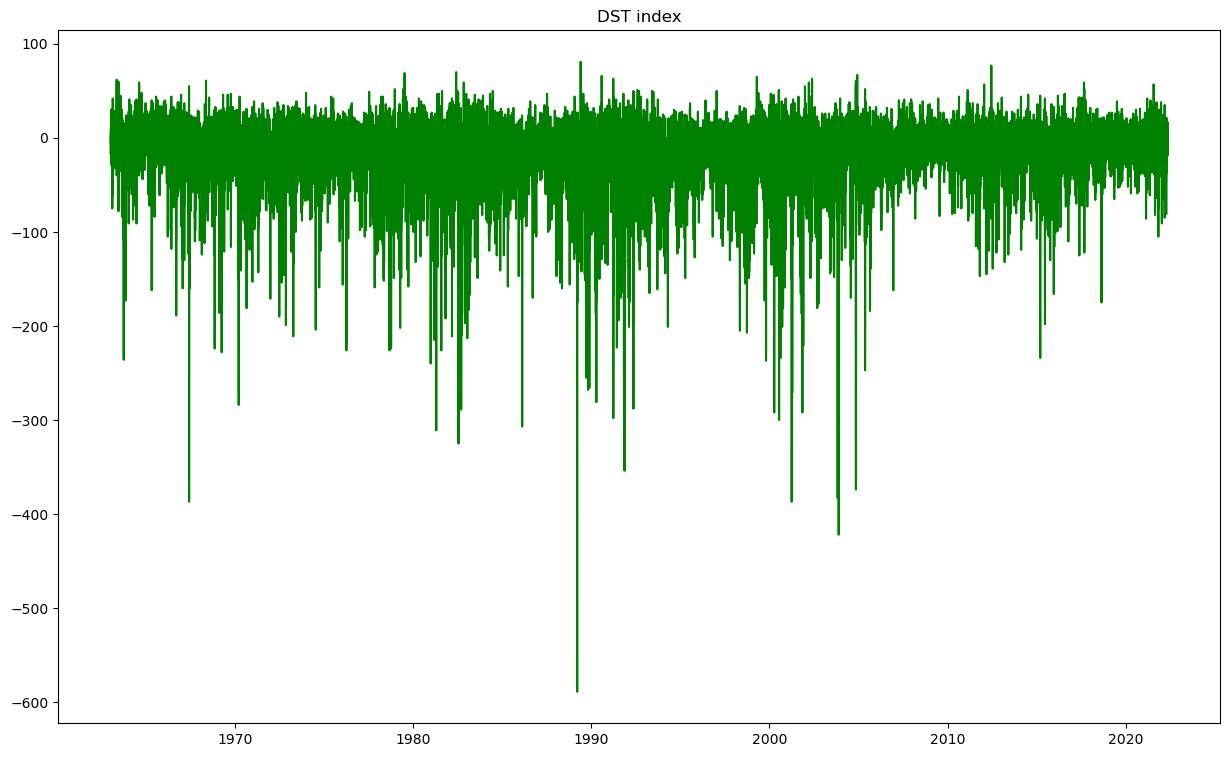

In [52]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index")
plt.plot(train['time1'],train['DST'], color='green')
plt.plot(valid['time1'],valid['DST'], color='green')
plt.plot(test['time1'],test['DST'], color='green')

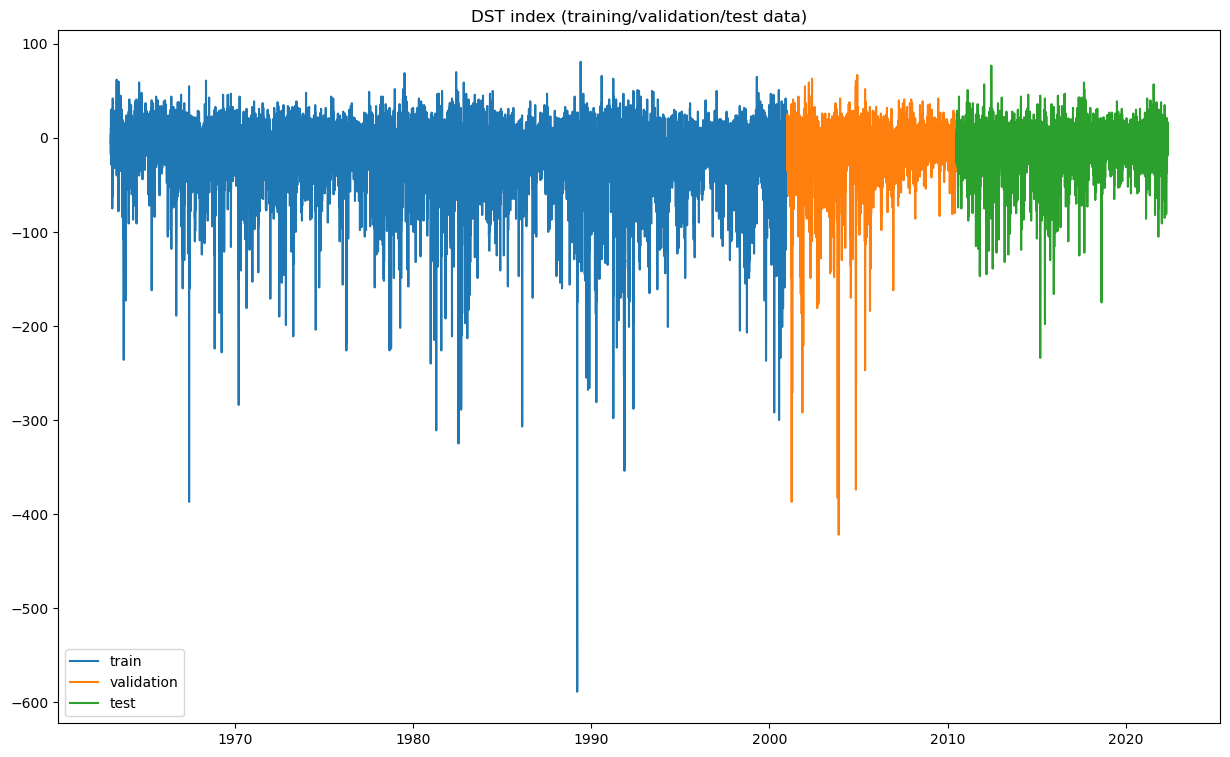

In [53]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index (training/validation/test data)")
plt.plot(train['time1'],train['DST'],label='train')
plt.plot(valid['time1'],valid['DST'],label='validation')
plt.plot(test['time1'],test['DST'],label='test')
plt.legend();

In [54]:
# set batch, n_input, n_features

n_input = 24  # how many samples/rows/timesteps to look in the past in order to forecast the next sample
n_features= len(X_train)  # how many predictors/Xs/features we have to predict y
b_size = 256  # Number of timeseries samples in each batch

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [14]:
for i in range(len(test_generator)):
	x, y = test_generator[i]
	print('tt %s => %s' % (x, y))

tt [[-13. -12. -12. ... -17. -25. -27.]
 [-12. -12. -17. ... -25. -27. -26.]
 [-12. -17. -17. ... -27. -26. -27.]
 ...
 [ -7.  -4.  -2. ...  -9.  -7.  -4.]
 [ -4.  -2.  -3. ...  -7.  -4.  -4.]
 [ -2.  -3.  -5. ...  -4.  -4.  -6.]] => [-26. -27. -27. -25. -26. -20. -16. -14. -14. -16. -16. -15. -13. -10.
 -15. -18. -21. -22. -18. -14. -15. -18. -19. -19. -16. -16. -17. -17.
 -15. -18. -15. -13. -12. -10. -14. -16. -16. -12. -10.  -9.  -9. -13.
 -17. -16. -21. -21. -19. -19. -17. -17. -19. -18. -19. -18. -16. -16.
 -16. -16. -14. -11.  -7.  -6. -11. -19. -22. -21. -18. -15. -13. -15.
 -13. -13. -12. -12.  -9. -10. -11. -14. -13. -12.  -8.  -4.  -1.  -1.
  -1.  -4.  -6.  -9. -12. -12. -15. -19. -21. -18. -16. -12. -12. -11.
 -12. -15. -17. -17. -15. -14. -13.  -9.  -8.  -9.  -9.  -8.  -5.  -3.
  -5.  -7.  -9. -12. -10. -11. -12. -11.  -9.  -9.  -8.  -9. -11. -10.
  -8.  -3.  -3.  -3.   0.  -2.  -5.  -6.  -5.  -6.  -6.  -4.  -4.  -6.
 -11. -13. -14. -14. -13. -12. -12. -14. -15. -15. -14. 

In [55]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1301
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  24


In [56]:
print("Počet batchov: ", len(test_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(test_generator[0]))
print("Dĺžka X zložky batchu: ", len(test_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(test_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(test_generator[0][0][0]))

Počet batchov:  407
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  24


In [57]:
print("Počet batchov: ", len(val_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(val_generator[0]))
print("Dĺžka X zložky batchu: ", len(val_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(val_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(val_generator[0][0][0]))

Počet batchov:  326
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  24


In [58]:
inputs = Input(shape=(n_input,1))
b = Conv1D(128, kernel_size = 4, padding = "same")(inputs)
b = Bidirectional(LSTM(128, dropout=0.1,recurrent_dropout=0.1))(inputs)
b = Dense(64, activation='relu')(b)
b = Dropout(0.2)(b)
x = Dense(32, activation='relu')(b)
output = Dense(1, activation='linear')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                             

In [59]:
inputs = Input(shape=(n_input,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 24, 256)          133120    
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 24, 128)           197120    
                                                                 
 time_distributed (TimeDistr  (None, 24, 1)            129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 25  

In [60]:
# callbacks
saved_model = "model_24.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [61]:
# fit
history = model.fit(train_generator, validation_data=val_generator, epochs=10, verbose=1, callbacks = callbacks_list)

Epoch 1/10
1301/1301 [==============================] - ETA: 0s - loss: 125.9014 - mae: 5.8561
Epoch 1: val_mae improved from inf to 3.37555, saving model to model_24.hdf5
1301/1301 [==============================] - 182s 137ms/step - loss: 125.9014 - mae: 5.8561 - val_loss: 49.4679 - val_mae: 3.3756
Epoch 2/10
1301/1301 [==============================] - ETA: 0s - loss: 50.8218 - mae: 4.1844
Epoch 2: val_mae improved from 3.37555 to 2.96417, saving model to model_24.hdf5
1301/1301 [==============================] - 173s 133ms/step - loss: 50.8218 - mae: 4.1844 - val_loss: 37.4644 - val_mae: 2.9642
Epoch 3/10
1301/1301 [==============================] - ETA: 0s - loss: 42.8522 - mae: 3.7656
Epoch 3: val_mae did not improve from 2.96417
1301/1301 [==============================] - 171s 132ms/step - loss: 42.8522 - mae: 3.7656 - val_loss: 32.0207 - val_mae: 3.0153
Epoch 4/10
1301/1301 [==============================] - ETA: 0s - loss: 36.1239 - mae: 3.5519
Epoch 4: val_mae did not improv

In [62]:
# load best model
model = keras.models.load_model('model_24.hdf5')

In [63]:
# prediction
y_pred = model.predict(test_generator)

407/407 [==============================] - 19s 46ms/step


Confusion matrix: 
[[82361   980]
 [ 3213 17498]]


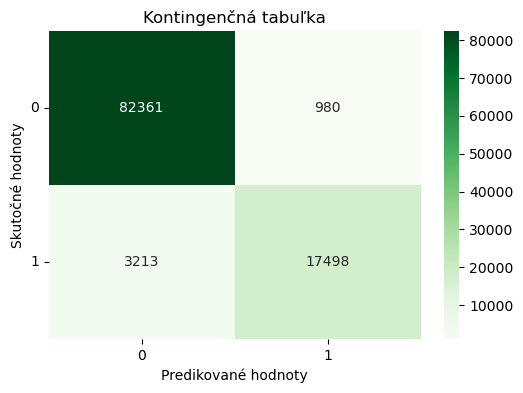

In [64]:
y_pred2 = np.where(y_pred <= -20, 1, 0)
y_test2 = np.where(y_test[n_input:] <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Kontingenčná tabuľka')
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], rotation=0)
plt.show()

In [65]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     83341
           1       0.95      0.84      0.89     20711

    accuracy                           0.96    104052
   macro avg       0.95      0.92      0.93    104052
weighted avg       0.96      0.96      0.96    104052



In [66]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [67]:
df

,time,y_true,y_predict
416379,2010-06-30 05:00:00,-26.0,-24.330364
416380,2010-06-30 06:00:00,-27.0,-23.581104
416381,2010-06-30 07:00:00,-27.0,-25.592489
416382,2010-06-30 08:00:00,-25.0,-24.807495
416383,2010-06-30 09:00:00,-26.0,-22.544725
...,...,...,...
520438,2022-05-13 12:00:00,2.0,1.452907
520439,2022-05-13 13:00:00,4.0,2.821833
520440,2022-05-13 14:00:00,5.0,4.834873
520441,2022-05-13 15:00:00,5.0,5.251668


In [68]:
df.describe()

,y_true,y_predict
count,104052.000000,104052.000000
mean,-9.639075,-9.537656
std,16.038445,15.638292
min,-234.000000,-220.379807
25%,-17.000000,-15.657985
50%,-7.000000,-6.762325
75%,0.000000,0.259162
max,77.000000,40.827286


<AxesSubplot:>

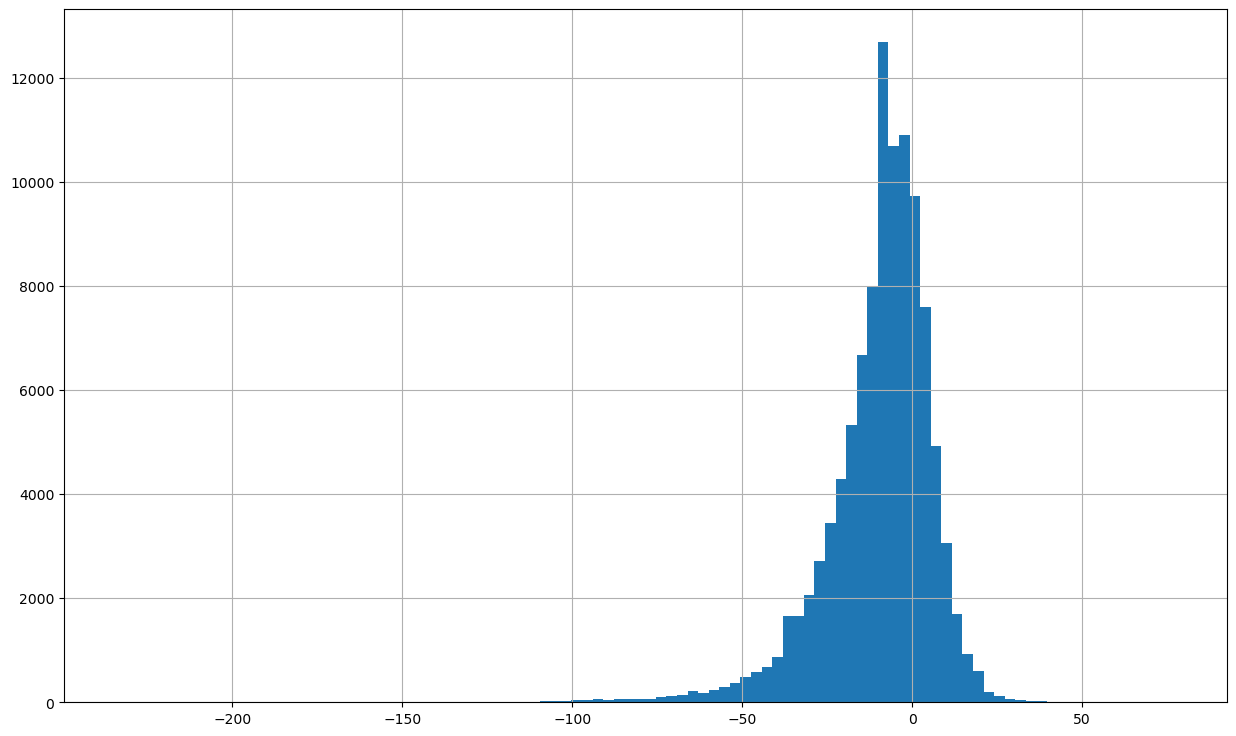

In [69]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

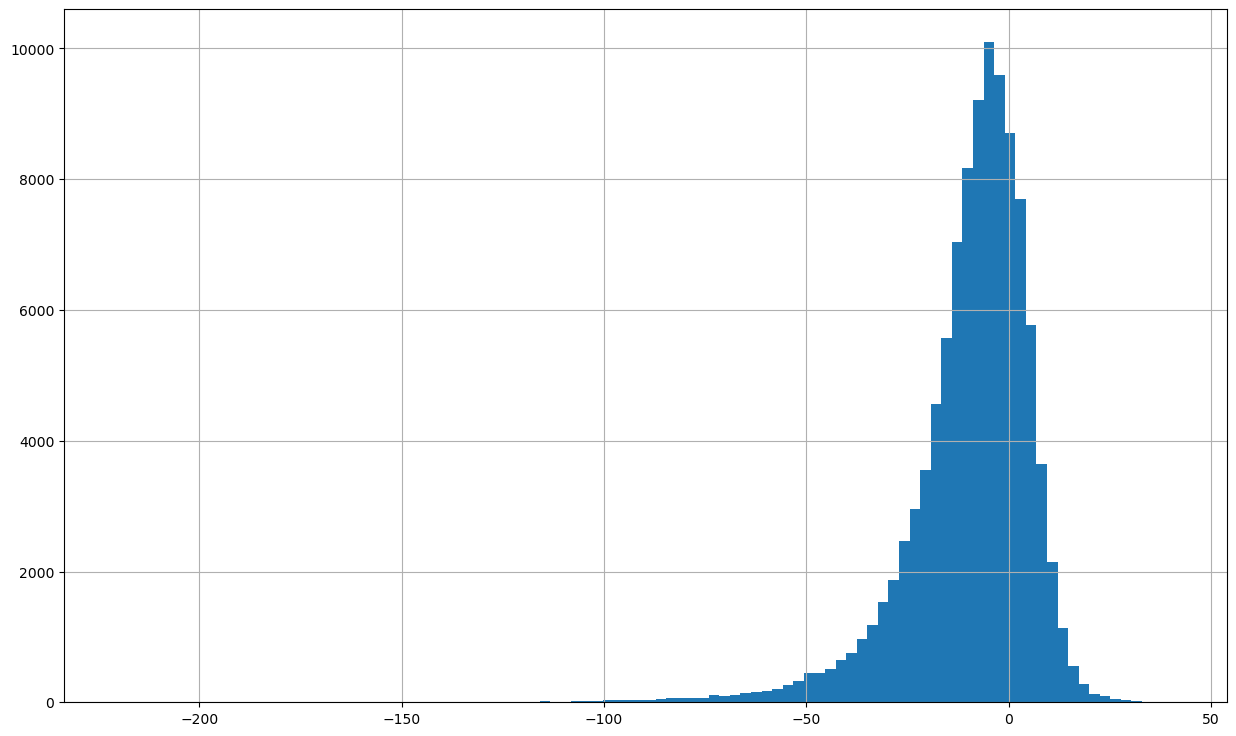

In [70]:
df["y_predict"].hist(bins=100)

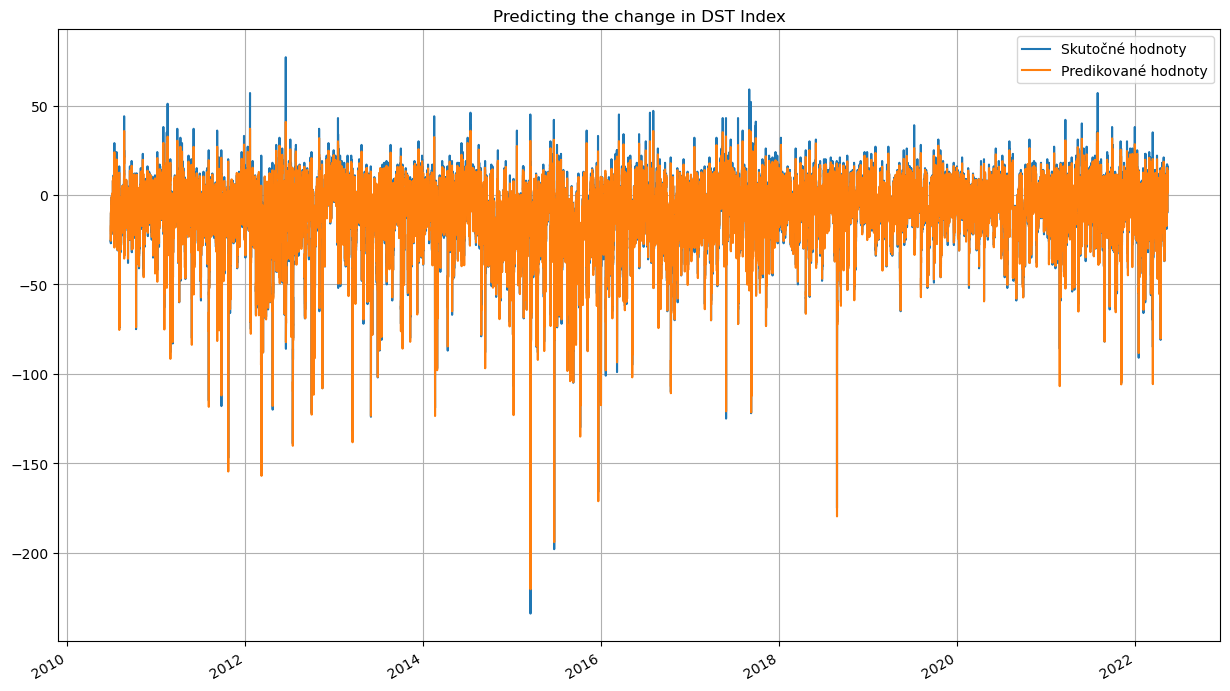

In [71]:
plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [72]:
df.to_csv('predikcie_24h_dozadu_1h_dopredu.csv')

# Vysvetliteľnosť modelu na základe DST indexu 1h dopredu 24 dozadu

In [73]:
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [74]:
#hodnota pre vypínanie intervalov priemer
value_for_shutdown = np.mean(X_test)
value_for_shutdown

-9.640512702256043

In [75]:
#hodnota pre vypínanie intervalov median
value_for_shutdown_median = np.median(X_test)
value_for_shutdown_median

-7.0

In [117]:
def XAI_for_DST_Prediction(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        for x in range(number_of_intervals):
            perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(n_input)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig

In [118]:
def XAI_for_DST_Prediction_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        for x in range(number_of_intervals):
            perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]

    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(interval_length)])
    
    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    
    
    time_data = np.arange(n_input+1)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+1],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+2, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.5) & (audio_scaled1[0:n_input+1] <= 0.6), color='yellow', alpha=0.3)
    plt.fill_between(time_data, ymin, ymax, where=(time_data >= time_data[-2]) & (time_data <= time_data[-1]), color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

1/1 [==============================] - 0s 23ms/step


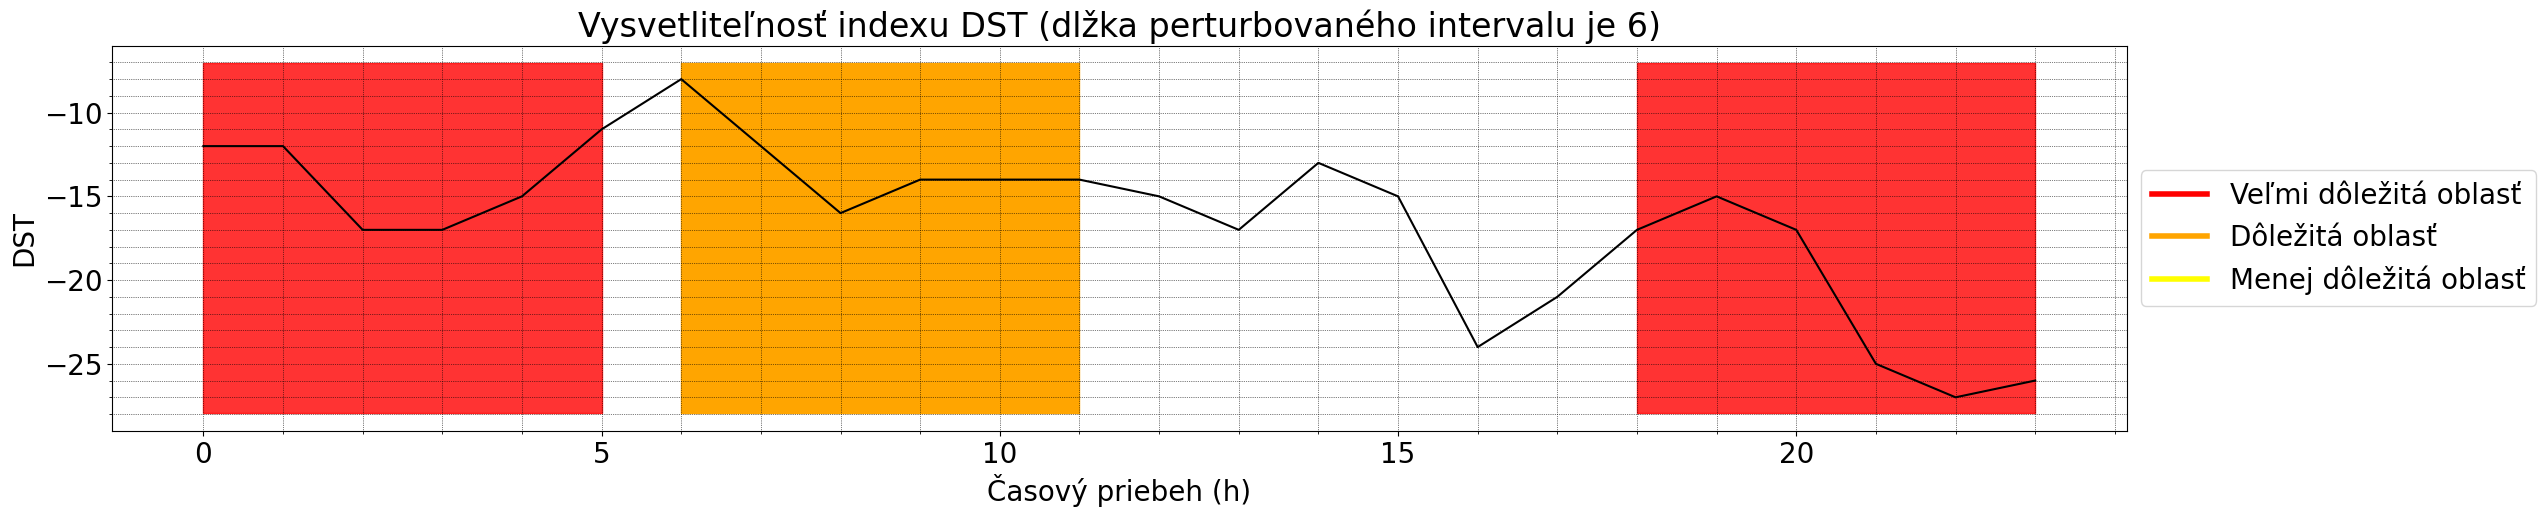

In [119]:
XAI_for_DST_Prediction(test_generator[0][0][1], model,6, value_for_shutdown)

1/1 [==============================] - 0s 23ms/step


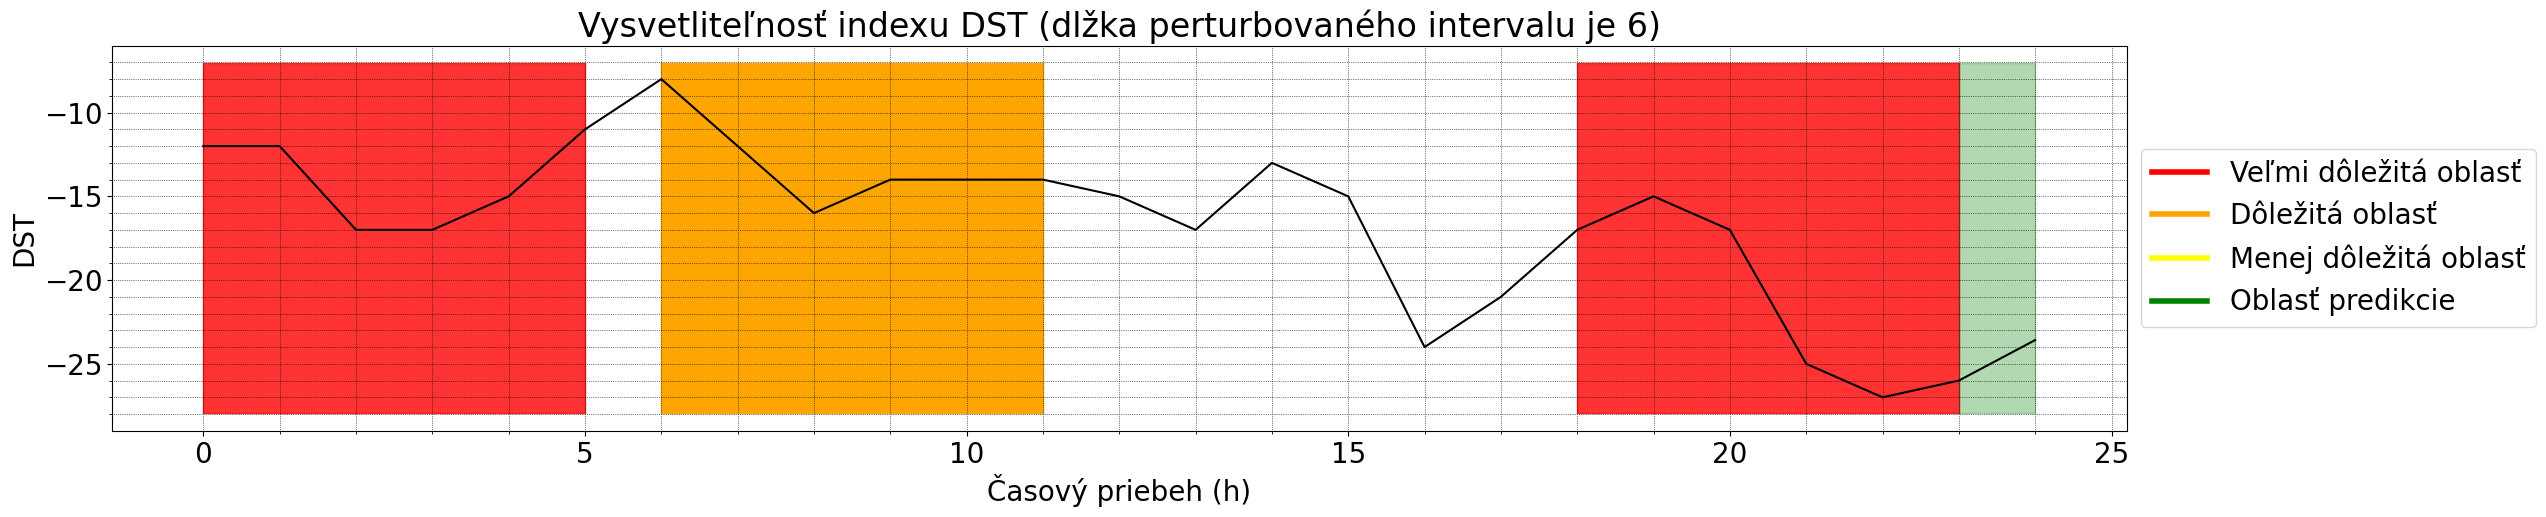

In [126]:
XAI_for_DST_Prediction_with_predicted_value(test_generator[0][0][1], model,6, value_for_shutdown)